## 1-D Transiet heat diffusion solver with Physics Informed Neural Networks 

**Import the libraries**

In [1]:
## Import basic numerical and plotting packages ##
from utils.importer import *

## Import the numerical PDE solver ##
from utils.numericalSolver import NumPDE

# ## Import the neural network dataprocessor and framework ##
from utils.PINN import DataPreprocessor, PINN

**Setup the calculation details**

The governing equation is by, 

$$\frac{\partial T}{\partial t} = \frac{\partial^2 T}{\partial x^2}$$  

The domain and time range is defined as follows, 

$$\forall \, x \in (0,l) \text{ and } 0 < t < t_{range}$$

Initial conditions are as follows,

$$T(x, 0) = 0 $$

Boundary conditions are defined as,

$$ \left.\frac{\partial T}{\partial x}\right\vert_{(0,t)} = 0 \text{ and } \left. T \right\vert_{(l,t)} = sin(t)$$

In [2]:
## total time of simulation and length of the system ##
trange, l = 2*np.pi, 1

## Package the time and spatial domain ##
extent = [[0, l], [0, trange]]

## Specify time and space discretizations ##
nx, nt = 256, 100

## Specify how much of available training data will be randomly picked for training in the domain, IC and BCs##
frac = {'ic': 0.8, 'bc': 0.8, 'dom' : 0.0}

## Specify the number of random points in the domain to evaluate PDE loss
N_f = 10000

## Neural Network structure ##
    ## Two inputs (x and t) and one output (temperature)
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

## Initialize the 1-D grid for the numerical solver ##
grid = CartesianGrid([[0, l]], nx)  

## Setup the initial condition of the system ##
    ## For the current problem it is set at 0 ##
field = ScalarField(grid, 0)        

## Definition of the diffusion PDE ##
    ## Specify diffusivity of the domain ##
diffusivity = 0.1
    ## Define the rhs of differential equation ##
rhs = f"(({diffusivity}) * laplace(c))"
    ## Specify the boundary conditions, first left end and then right end ##
bc = [[{'derivative':0}, {'value_expression':'sin(t)'}]]
    ## package thegoverning equation and boundary conditions ##
eq = PDE({"c": f"{rhs}"}, bc=bc)

**Obtain the numerical solution**

In [3]:
## Obtain the numerical solution ##
    ## We use explicit RK-4 adaptive time stepping ##
    ## Also specified the time discretization  using the variable nt ##
if os.path.isfile('saved/numSol.pkl'):
    with open('saved/numSol.pkl', 'rb') as file:
        numSol = pkl.load(file)
else:
    numSol = NumPDE(eq, grid, field, 'Explicit', trange, trange/nt).ground_truth

**Create the NN data from numerical solution**

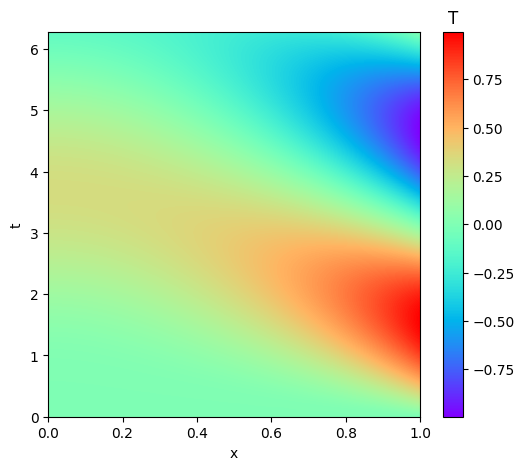

In [4]:
NNdata = DataPreprocessor(numSol, frac, extent, N_f)

**Setup the NN, train and save the weights**

In [5]:
model = PINN(NNdata, layers, diffusivity, 10000, 100)
if os.path.isfile('saved/best_model'):
    model.dnn.load_state_dict(torch.load('saved/best_model', map_location=torch.device('cpu')))
else:
    model.train()

**Run the predictions**

Total average error on the prediction w.r.t ground truth = 0.006466445850262898


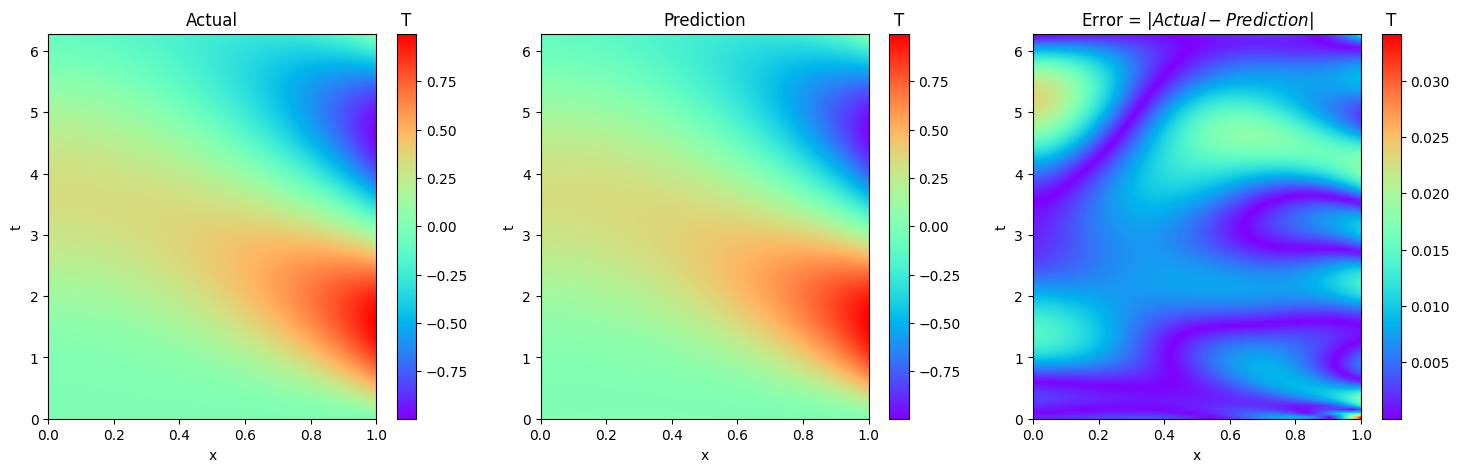

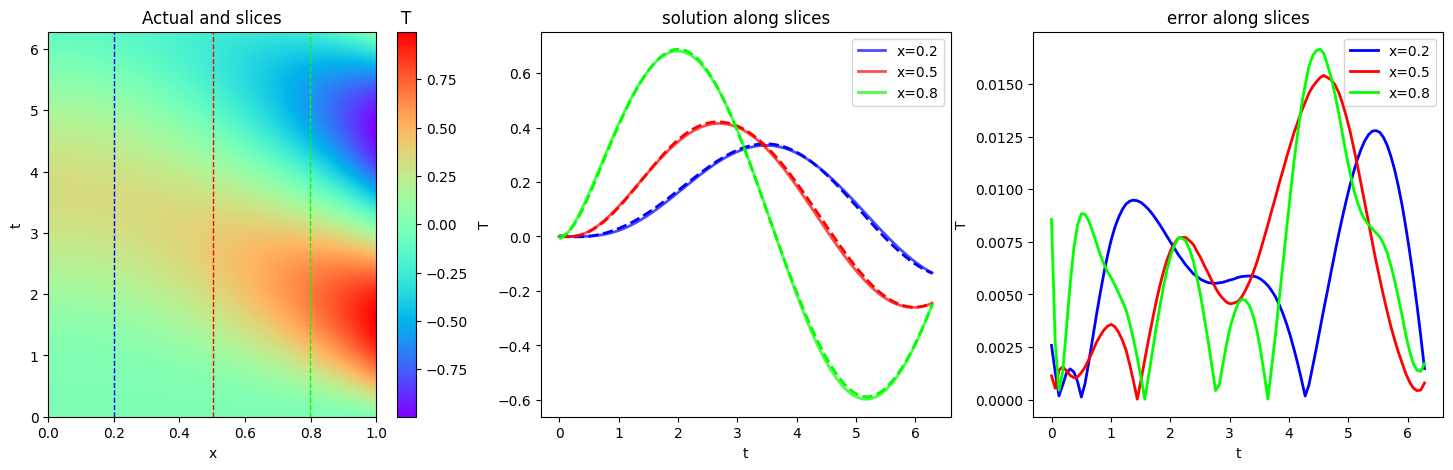

In [6]:
model.predict(NNdata, [0.2, 0.50, 0.8], extent)